## Install TensorTrade

In [ ]:
!unzip TensorTrader.zip
#!rm TensorTrader.zip
%cd TensorTrader
!pip install -r requirements.txt
!python setup.py install

Archive:  TensorTrader.zip
   creating: TensorTrader/
   creating: TensorTrader/.config/
  inflating: TensorTrader/.config/.last_opt_in_prompt.yaml  
  inflating: TensorTrader/.config/.last_survey_prompt.yaml  
  inflating: TensorTrader/.config/.last_update_check.json  
  inflating: TensorTrader/.config/.metricsUUID  
  inflating: TensorTrader/.config/active_config  
   creating: TensorTrader/.config/configurations/
  inflating: TensorTrader/.config/configurations/config_default  
 extracting: TensorTrader/.config/config_sentinel  
  inflating: TensorTrader/.config/gce  
   creating: TensorTrader/.config/logs/
   creating: TensorTrader/.config/logs/2020.08.27/
  inflating: TensorTrader/.config/logs/2020.08.27/16.38.36.398860.log  
  inflating: TensorTrader/.config/logs/2020.08.27/16.38.54.457558.log  
  inflating: TensorTrader/.config/logs/2020.08.27/16.39.08.060972.log  
  inflating: TensorTrader/.config/logs/2020.08.27/16.39.13.109523.log  
  inflating: TensorTrader/.config/logs/2020

## Setup Data Fetching

In [ ]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent


%matplotlib inline

In [ ]:
cdd = CryptoDataDownload()

data = cdd.fetch("Coinbase", "USD", "BTC", "1h")

In [ ]:
data['datetime'] = pd.to_datetime(data['date']).dt.year

In [ ]:
data = data[data.datetime ==2020].drop(columns=['datetime'])

In [ ]:
data.head()

,date,unix timestamp,open,high,low,close,volume
21925,2020-01-01 00:00:00,1.577837e+09,7165.72,7165.72,7136.05,7150.35,1794532.12
21926,2020-01-01 01:00:00,1.577840e+09,7150.35,7204.94,7147.18,7194.52,1667515.27
21927,2020-01-01 02:00:00,1.577844e+09,7194.52,7218.42,7191.44,7217.00,1368696.24
21928,2020-01-01 03:00:00,1.577848e+09,7217.00,7217.00,7193.34,7196.98,1691433.85
21929,2020-01-01 04:00:00,1.577851e+09,7196.98,7200.62,7183.85,7186.41,1481283.70


In [ ]:
data1 = data[:250]
data1 = data1.reset_index()

In [ ]:
data1.iloc[24]

index                           21949
date              2020-01-02 00:00:00
unix timestamp            1.57792e+09
open                          7174.33
high                          7186.18
low                              7160
close                         7181.99
volume                         660243
Name: 24, dtype: object

In [ ]:
(data1[['high','low','close']] - data1[['high','low','close']].mean()).describe()

,high,low,close
count,2.500000e+02,2.500000e+02,2.500000e+02
mean,2.368324e-12,-1.189619e-12,-4.583853e-13
std,4.019320e+02,3.791484e+02,3.903524e+02
min,-6.984922e+02,-7.065785e+02,-7.259266e+02
25%,-3.079297e+02,-2.950060e+02,-2.971541e+02
50%,-8.825724e+01,-6.962348e+01,-7.587160e+01
75%,3.231478e+02,3.134990e+02,3.094484e+02
max,8.433178e+02,7.887515e+02,8.517434e+02


In [ ]:
percent=.8

train_data = data[:int(percent*len(data))]
test_data = data[int(percent*len(data)):]

In [ ]:
len(train_data),len(test_data)

(5344, 1336)

## Create features with the feed module
### log(close),RSI, MACD

In [ ]:
def rsi(price: Stream[float], period: float) -> Stream[float]:
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)


def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal


features = []
for c in test_data.columns[1:]:
    s = Stream.source(list(test_data[c]), dtype="float").rename(test_data[c].name)
    features += [s]

cp = Stream.select(features, lambda s: s.name == "close")

features = [
    cp.log().diff().rename("lr"),
    rsi(cp, period=20).rename("rsi"),
    macd(cp, fast=10, slow=50, signal=5).rename("macd")
]

test_feed = DataFeed(features)
test_feed.compile()

In [ ]:
features = []
for c in train_data.columns[1:]:
    s = Stream.source(list(train_data[c]), dtype="float").rename(train_data[c].name)
    features += [s]

cp = Stream.select(features, lambda s: s.name == "close")

features = [
    cp.log().diff().rename("lr"),
    rsi(cp, period=20).rename("rsi"),
    macd(cp, fast=10, slow=50, signal=5).rename("macd")
]

train_feed = DataFeed(features)
train_feed.compile()

In [ ]:
train_feed.next()

{'lr': nan, 'macd': 0.0, 'rsi': nan}

## Setup Trading Environment

In [ ]:
coinbase = Exchange("coinbase", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC)
])


test_renderer_feed = DataFeed([
    Stream.source(list(test_data["date"])).rename("date"),
    Stream.source(list(test_data["open"]), dtype="float").rename("open"),
    Stream.source(list(test_data["high"]), dtype="float").rename("high"),
    Stream.source(list(test_data["low"]), dtype="float").rename("low"),
    Stream.source(list(test_data["close"]), dtype="float").rename("close"), 
    Stream.source(list(test_data["volume"]), dtype="float").rename("volume") 
])

train_renderer_feed = DataFeed([
    Stream.source(list(train_data["date"])).rename("date"),
    Stream.source(list(train_data["open"]), dtype="float").rename("open"),
    Stream.source(list(train_data["high"]), dtype="float").rename("high"),
    Stream.source(list(train_data["low"]), dtype="float").rename("low"),
    Stream.source(list(train_data["close"]), dtype="float").rename("close"), 
    Stream.source(list(train_data["volume"]), dtype="float").rename("volume") 
])

env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=train_feed,
    renderer_feed=train_renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    window_size=20
)

## Risk-Adjusted Returns reward scheme has Sharpe Ratio as default which uses the Portfolio.
https://en.wikipedia.org/wiki/Sharpe_ratio

## Setup and restore DQN Agent

In [ ]:
agent = DQNAgent(env)

In [ ]:
#current_policy = "policy_network__f7942921-91d1-4625-b8b5-d979db2bd9b2__099_100.hdf5"
current_policy = "policy_network__b34933bc-314e-43be-a587-dff866cffa8e__099_60.hdf5"

In [ ]:
agent.restore(current_policy)

In [ ]:
##DQNAgent implemented in TT, running it here to avoid excessively restarting runtime 
import random
import numpy as np
import tensorflow as tf
from collections import namedtuple
import tqdm

from tensortrade.agents import Agent, ReplayMemory


DQNTransition = namedtuple('DQNTransition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent1(Agent):

    def __init__(self,
                 env: 'TradingEnv',
                 policy_network: tf.keras.Model = None):
        self.env = env
        self.n_actions = env.action_space.n
        self.observation_shape = env.observation_space.shape

        self.policy_network = policy_network or self._build_policy_network()

        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

        self.env.agent_id = self.id

    def _build_policy_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.observation_shape),
            tf.keras.layers.Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_actions, activation="sigmoid"),
            tf.keras.layers.Dense(self.n_actions, activation="softmax")
        ])

        return network

    def restore(self, path: str, **kwargs):
        self.policy_network = tf.keras.models.load_model(path)
        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

    def save(self, path: str, **kwargs):
        episode: int = kwargs.get('episode', None)

        if episode:
            filename = "policy_network__" + self.id + "__" + str(episode).zfill(3) + ".hdf5"
        else:
            filename = "policy_network__" + self.id + ".hdf5"

        self.policy_network.save(path + filename)

    def get_action(self, state: np.ndarray, **kwargs) -> int:
        threshold: float = kwargs.get('threshold', 0)

        rand = random.random()

        if rand < threshold:
            choice = np.random.choice(self.n_actions)
            return choice
        else:
            choice = np.argmax(self.policy_network(np.expand_dims(state, 0)))
            return choice
    def get_action_greedy(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmax(qvalues)
        return choice
    def get_worst_action(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmin(qvalues)
        return choice

    def create_perturbation(self,modelfn, input_vector, original_label):
        loss_object = tf.keras.losses.Huber()
      
        # Reference the docs for GradientTape in tf2.0 for more info
        with tf.GradientTape() as gt:
          # Define the calculation that needs to be derived
          gt.watch(input_vector)
          prediction = modelfn(input_vector)
          loss = loss_object(original_label, prediction[0]) ## remove [0] if it's inside a tuple
        # Get the gradients for the loss w.r.t image
        grads = gt.gradient(loss, input_vector)
        perturbation = tf.sign(grads)
        return perturbation

    def fgsm(self,modelfn, input_vector, original_label, epsilon,target=False):
        perturbation = self.create_perturbation(modelfn, input_vector, original_label)
        if target == False:
          adv_example = input_vector + (perturbation * epsilon)
        else:
          adv_example = input_vector - (perturbation * epsilon)
        return adv_example


    def _apply_gradient_descent(self, memory: ReplayMemory, batch_size: int, learning_rate: float, discount_factor: float):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        loss = tf.keras.losses.Huber()

        transitions = memory.sample(batch_size)
        batch = DQNTransition(*zip(*transitions))

        state_batch = tf.convert_to_tensor(batch.state)
        action_batch = tf.convert_to_tensor(batch.action)

        reward_batch = tf.convert_to_tensor(batch.reward, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(batch.next_state)
        done_batch = tf.convert_to_tensor(batch.done)

        with tf.GradientTape() as tape:
            
            state_action_values = tf.math.reduce_sum(
                self.policy_network(state_batch) * tf.one_hot(action_batch, self.n_actions),
                axis=1
            )
            next_state_values = tf.where(
                done_batch,
                tf.zeros(batch_size),
                tf.math.reduce_max(self.target_network(next_state_batch), axis=1)
            )

            expected_state_action_values = reward_batch + (discount_factor * next_state_values)
            loss_value = loss(expected_state_action_values, state_action_values)

        variables = self.policy_network.trainable_variables
        gradients = tape.gradient(loss_value, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    def train(self,
              n_steps: int = None,
              n_episodes: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        stop_training = False

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes and not stop_training:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                threshold = eps_end + (eps_start - eps_end) * np.exp(-total_steps_done / eps_decay_steps)
                action = self.get_action(state, threshold=threshold)
                next_state, reward, done, _ = self.env.step(action)


                memory.push(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward
                steps_done += 1
                total_steps_done +=1

                if len(memory) < batch_size:
                    continue

                self._apply_gradient_descent(memory, batch_size, learning_rate, discount_factor)

                if n_steps and steps_done >= n_steps:
                    done = True

                if render_interval is not None and steps_done % render_interval == 0:
                    self.env.render(
                        episode=episode,
                        max_episodes=n_episodes,
                        max_steps=n_steps
                    )

                if steps_done % update_target_every == 0:
                    self.target_network = tf.keras.models.clone_model(self.policy_network)
                    self.target_network.trainable = False

            is_checkpoint = save_every and episode % save_every == 0

            if save_path and (is_checkpoint or episode == n_episodes - 1):
                self.save(save_path, episode=episode)

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done

        return mean_reward

    def test(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        total_reward_array=[]
        networth=[]

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                action = self.get_action_greedy(state)
                
                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                networth.append(self.env.action_scheme.portfolio.net_worth)
                total_reward_array.append(total_reward)
                steps_done += 1
                total_steps_done +=1

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        return mean_reward,total_reward_array,networth


    def delay(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              delay_step: int = 1,
              delay_chance: float = 1.0,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        tra = []
        networth=[]

        perbarray = []

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0
            if steps_done == 0:
              ##saving the previous timestep tuple of values
              currentWindow = state[-1].copy()   

            while not done:
                action = self.get_action_greedy(state)
                
                next_state, reward, done, _ = self.env.step(action)
                #saving previous state so we can preserve N-1 observation tuples
                prev_state = state.copy()

                state = next_state
                total_reward += reward
                tra.append(total_reward)
                networth.append(self.env.action_scheme.portfolio.net_worth)
                steps_done += 1
                total_steps_done +=1
                #nextWindow is the most recent tuple
                nextWindow = state[-1].copy()
                perbarray.append(nextWindow)
                #manually preserving the history
                state[:-1] = prev_state[1:]
                
                if len(perbarray) <= delay_step:
                  ### in the case our timestep - delay_step < 0, just use the first observation
                  currentWindow = perbarray[0]
                else:
                  ## pop the first element which is the (timestep - delay_step) timestep
                  currentWindow = perbarray.pop(0)

                if np.random.random() < delay_chance:
                  ##overwrite the new tuple with the delay tuple
                  state[-1] = currentWindow

                currentWindow = nextWindow
                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        return mean_reward,tra,networth

In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)

# OBSERVATIONAL DELAY

In [ ]:
control_mean_reward, control_reward_array,networth0 = agent1.test(n_steps=250,n_episodes=1,render_interval=None)

====      AGENT ID: 40aa1071-9691-4dec-bb72-99f5e5c598c9      ====


/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide



FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)
delay_mean, delay_reward_array,networth00 = agent1.delay(n_steps=250,n_episodes=1,render_interval=None,delay=1,delay_chance=1.0)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 96%|█████████▋| 241/250 [00:02<00:00, 98.13it/s] 

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)
delay_mean_chance1, delay_reward_chance1_array,networth01 = agent1.delay(n_steps=250,n_episodes=1,render_interval=None,delay=1,delay_chance=0.5)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 96%|█████████▋| 241/250 [00:02<00:00, 101.14it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 91.91it/s] 


In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)
delay_mean_chance2, delay_reward_chance2_array,networth02 = agent1.delay(n_steps=250,n_episodes=1,render_interval=None,delay=1,delay_chance=0.1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 98%|█████████▊| 245/250 [00:02<00:00, 99.13it/s] 

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 88.57it/s]


In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)
delay_mean_chance3, delay_reward_chance3_array,networth04 = agent1.delay(n_steps=250,n_episodes=1,render_interval=None,delay=1,delay_chance=0.01)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|█████████▉| 249/250 [00:02<00:00, 106.03it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 96.24it/s] 


In [ ]:
agent1 = DQNAgent1(env)
agent1.restore(current_policy)
delay_mean_chance4, delay_reward_chance4_array,networth05 = agent1.delay(n_steps=250,n_episodes=1,render_interval=None,delay=1,delay_chance=0.9)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 97%|█████████▋| 242/250 [00:02<00:00, 108.67it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 96.44it/s] 


In [ ]:
import numpy as np

np.savetxt("control_reward_array.out",control_reward_array , delimiter=",")
np.savetxt("delay_reward_array.out",delay_reward_array , delimiter=",")
np.savetxt("delay_reward_chance4_array.out",delay_reward_chance4_array , delimiter=",")
np.savetxt("delay_reward_chance1_array.out",delay_reward_chance1_array , delimiter=",")
np.savetxt("delay_reward_chance2_array.out",delay_reward_chance2_array , delimiter=",")
np.savetxt("delay_reward_chance3_array.out",delay_reward_chance3_array , delimiter=",")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


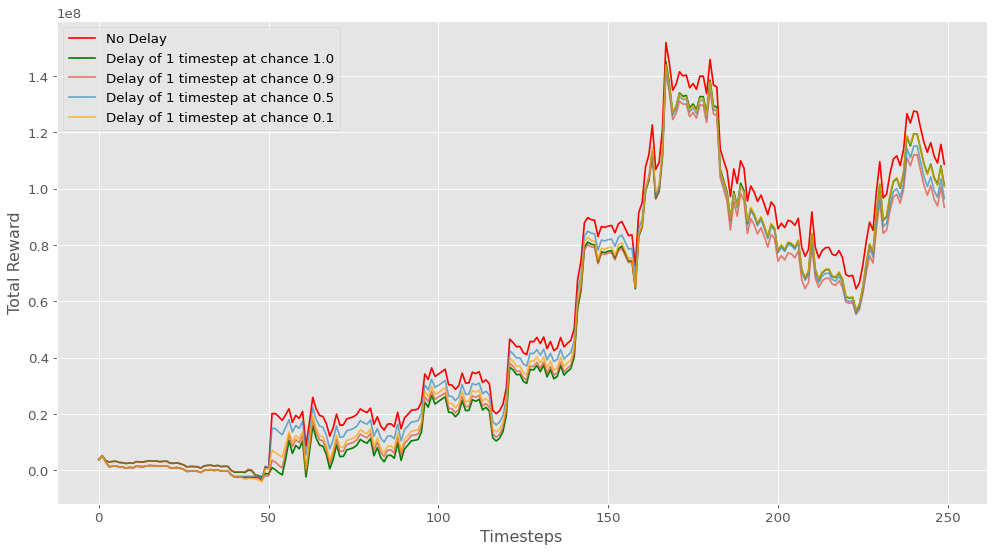

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(control_reward_array,label="No Delay",color='red')
plt.plot(delay_reward_array,label="Delay of 1 timestep at chance 1.0",color='green')
plt.plot(delay_reward_chance4_array,label="Delay of 1 timestep at chance 0.9",alpha=.7)
plt.plot(delay_reward_chance1_array,label="Delay of 1 timestep at chance 0.5",alpha=.7)
plt.plot(delay_reward_chance2_array,label="Delay of 1 timestep at chance 0.1",alpha=.7,color='orange')
#plt.plot(delay_reward_chance3_array,label="Delay of 1 timestep at chance 0.01",alpha=.5,color='blue')
plt.ylabel("Total Reward")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_delay.eps")
plt.show()

#CONTROL

In [ ]:
import copy

In [ ]:
env1 = copy.deepcopy(env)

In [ ]:
agent1 = DQNAgent1(env1)
agent1.restore(current_policy)

NameError: ignored

In [ ]:
control_mean_reward, control_reward_array,networth0 = agent1.test(n_steps=250,n_episodes=1,render_interval=None)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide



FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

In [ ]:
control_mean_reward,agent1.env.action_scheme.portfolio.net_worth

(434259.99413430074, 90496.2333227268)

#Other things

##Log(Close) --> 0 < x < inf
##RSI --> 0 < x < 100
##MACD --> Range depends on Underlying Security but has a larger range than Log(Close)

# FGSM Non-Target Attack

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import namedtuple
import tqdm

from tensortrade.agents import Agent, ReplayMemory


DQNTransition = namedtuple('DQNTransition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent2(Agent):

    def __init__(self,
                 env: 'TradingEnv',
                 policy_network: tf.keras.Model = None):
        self.env = env
        self.n_actions = env.action_space.n
        self.observation_shape = env.observation_space.shape

        self.policy_network = policy_network or self._build_policy_network()

        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

        self.env.agent_id = self.id

    def _build_policy_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.observation_shape),
            tf.keras.layers.Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_actions, activation="sigmoid"),
            tf.keras.layers.Dense(self.n_actions, activation="softmax")
        ])

        return network

    def restore(self, path: str, **kwargs):
        self.policy_network = tf.keras.models.load_model(path)
        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

    def save(self, path: str, **kwargs):
        episode: int = kwargs.get('episode', None)

        if episode:
            filename = "policy_network__" + self.id + "__" + str(episode).zfill(3) + ".hdf5"
        else:
            filename = "policy_network__" + self.id + ".hdf5"

        self.policy_network.save(path + filename)

    def get_action(self, state: np.ndarray, **kwargs) -> int:
        threshold: float = kwargs.get('threshold', 0)

        rand = random.random()

        if rand < threshold:
            choice = np.random.choice(self.n_actions)
            return choice
        else:
            choice = np.argmax(self.policy_network(np.expand_dims(state, 0)))
            return choice
    def get_action_greedy(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmax(qvalues)
        return choice
    def get_worst_action(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmin(qvalues)
        return choice

    def create_perturbation(self,modelfn, input_vector, original_label):
        loss_object = tf.keras.losses.Huber()
      
        # Reference the docs for GradientTape in tf2.0 for more info
        with tf.GradientTape() as gt:
          # Define the calculation that needs to be derived
          gt.watch(input_vector)
          prediction = modelfn(input_vector)
          loss = loss_object(original_label, prediction[0]) ## remove [0] if it's inside a tuple
        # Get the gradients for the loss w.r.t image
        grads = gt.gradient(loss, input_vector)
        perturbation = tf.sign(grads)
        return perturbation

    def fgsm(self,modelfn, input_vector, original_label, epsilon,target=False):
        perturbation = self.create_perturbation(modelfn, input_vector, original_label)
        perturbation = perturbation.numpy() #shape (1,20,3)
        #scale down the values - lr,macd,rsi
        #this is our vector of scalars [k1,k2,k3]
        perturbation[0][-1][0] = perturbation[0][-1][0]*0.01
        #perturbation[0][-1][1] = perturbation[0][-1][0]*0.01
        perturbation[0][-1][2] = perturbation[0][-1][2] *0.1
        perturbation = tf.convert_to_tensor(perturbation)
        if target == False:
          adv_example = input_vector + (perturbation * epsilon)
        else:
          adv_example = input_vector - (perturbation * epsilon)
        return adv_example

    def train(self,
              n_steps: int = None,
              n_episodes: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        stop_training = False

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        pass
    def get_trajectory(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              max: bool = True,

              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20

        action_array=[]

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                if max == True:
                  action = self.get_action_greedy(state)
                else:
                  action = self.get_worst_action(state)

                action_array.append(action)
                
                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                steps_done += 1
                total_steps_done +=1

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        print(mean_reward)
        return action_array


    def non_target_fgsm(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              chance: float = 1.0,
              iterations: int =5,
              start_eps: float = 0.001,
              end_eps: float = 0.01,
              max_actions: bool = False,
              writeToFile: bool = False,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        tra = []
        tra2=[]
        failCount=0
        noChangeNeeded=0
        pertCount=0
        networth=[]

        if writeToFile == True:
          writefile = open('nontarget_fgsm.txt','w+')

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        def actiontype(a):
          if env.action_scheme.actions[a] == None:
            return "None"
          else:
            return env.action_scheme.actions[a][-1][-1]

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                trueWindow = state[-1].copy()
                action = self.get_action_greedy(state)

                label = max_actions[steps_done] ##the true action to take at a timestep t

                if label!= action and  actiontype(label) != actiontype(action):
                  #agent's action is already not the best action and is not the same type of action
                  noChangeNeeded+=1
                elif steps_done!=0 and np.random.random() < chance:
                  pertCount+=1
                  fgsm_state = self.fgsm(self.policy_network, tf.convert_to_tensor(np.expand_dims(state,0)), label, start_eps,target=False)
                  #state shape is (20,3), fgsm_state is shape (1,20,3)
                  state[-1] = fgsm_state[0][-1]
                  #to make this adversarial attack more constrained, we must abide by the direction of the prices.
                  for i in range(len(trueWindow)):
                      if trueWindow[i] >= 0 and state[-1][i] <= 0:
                        state[-1][i] = -state[-1][i]
                      elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                        state[-1][i] =-state[-1][i]
                  action = self.get_action_greedy(state)

                  if label==action or actiontype(label) == actiontype(action):
                      ##the action may have changed, but we are interested that it is not the same type of action
                      diff = end_eps - start_eps
                      increasing_eps = start_eps
                      for t in range(0,iterations):
                        increasing_eps+=diff/iterations
                        state[-1] =trueWindow
                        fgsm_state = self.fgsm(self.policy_network, tf.convert_to_tensor(np.expand_dims(state,0)), label, increasing_eps,target=False)
                        state[-1] = fgsm_state[0][-1]
                        for i in range(len(trueWindow)):
                            if trueWindow[i] >= 0 and state[-1][i] <= 0:
                              state[-1][i] = -state[-1][i]
                            elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                              state[-1][i] =-state[-1][i]
                        action = self.get_action_greedy(state)
                        if label!=action and actiontype(label) != actiontype(action):
                          #the action changed, break out
                          break
                  if label==action or actiontype(label) == actiontype(action):
                    ##final check for action
                    failCount+=1
                    #reassign the modified state to the original if the attack fails
                    state[-1] =trueWindow
                  else:
                    if writeToFile == True:
                      writefile.write("\n Timestep:"+str(steps_done))
                      writefile.write("\n True OBS:"+str(trueWindow))
                      writefile.write("\n Perturbed OBS:"+str(state[-1]))
                      writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                      writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                prev_state = state.copy()

                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                tra.append(total_reward)
                networth.append(self.env.action_scheme.portfolio.net_worth)
                steps_done += 1
                total_steps_done +=1

                state[:-1] = prev_state[1:]

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        print("Total Reward:",total_reward)
        print("Mean Reward:",mean_reward)
        print("PertCount:",pertCount)
        print("FailCount:", failCount)
        print("noChangeNeeded:",noChangeNeeded)
        print("Agent's Net Worth:",env.action_scheme.portfolio.net_worth)
        others=[]
        others =[
        self.env.action_scheme.portfolio.net_worth,\
        self.env.action_scheme.portfolio.initial_balance,\
        self.env.action_scheme.portfolio.initial_net_worth,\
        self.env.action_scheme.portfolio.balances,\
        self.env.action_scheme.portfolio.ledger.transactions
        ]
        if writeToFile == True:
          writefile.close()
        return mean_reward,tra,others,networth




    def target_fgsm(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              chance: float = 1.0,
              iterations: int =5,
              start_eps: float = 0.001,
              end_eps: float = 0.01,
              max_actions: bool = False,
              min_actions: bool = False,
              writeToFile: bool = False,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        tra = []
        tra2=[]
        failCount=0
        noChangeNeeded=0
        pertCount=0
        nontargetattack=0
        networth=[]
        partialSuccess=0

        def actiontype(a):
          if env.action_scheme.actions[a] == None:
            return "None"
          else:
            return env.action_scheme.actions[a][-1][-1]

        if writeToFile == True:
          writefile = open('target_fgsm.txt','w+')

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                trueWindow = state[-1].copy()
                action = self.get_action_greedy(state)

                best = max_actions[steps_done] ##the true action to take at a timestep t
                label = min_actions[steps_done] ##the desired action to take at a timestep t

                if label == action:
                  #agent's action is what we want
                  noChangeNeeded+=1
                elif steps_done!=0 and np.random.random() < chance:
                  pertCount+=1
                  state[-1] =trueWindow
                  fgsm_state = self.fgsm(self.policy_network, tf.convert_to_tensor(np.expand_dims(state,0)), label, start_eps,target=True)
                  #state shape is (20,3), fgsm_state is shape (1,20,3)
                  state[-1] = fgsm_state[0][-1]
                  #to make this adversarial attack more constrained, we must abide by the direction of the prices.
                  for i in range(len(trueWindow)):
                      if trueWindow[i] >= 0 and state[-1][i] <= 0:
                        state[-1][i] = -state[-1][i]
                      elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                        state[-1][i] =-state[-1][i]
                  action = self.get_action_greedy(state)

                  if label!=action:
                      ##still not the desired action
                      diff = end_eps - start_eps
                      increasing_eps = start_eps
                      for t in range(0,iterations):
                        increasing_eps+=diff/iterations
                        fgsm_state = self.fgsm(self.policy_network, tf.convert_to_tensor(np.expand_dims(state,0)), label, increasing_eps,target=True)
                        state[-1] = fgsm_state[0][-1]
                        for i in range(len(trueWindow)):
                            if trueWindow[i] >= 0 and state[-1][i] <= 0:
                              state[-1][i] = -state[-1][i]
                            elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                              state[-1][i] =-state[-1][i]

                        action = self.get_action_greedy(state)
                        if label==action:
                          #the action changed, break out
                          break
                  if label!=action:
                    failCount+=1
                    ##final check for action
                    if action != best:
                      #is a nontarget attack
                      nontargetattack+=1
                    if actiontype(label)!=actiontype(action):
                      ## we have at least changed the action to the same action type
                      partialSuccess+=1
                      #we will be lenient to perserve partial success attacks
                      if writeToFile == True:
                        writefile.write("\n Partial Success")
                        writefile.write("\n Timestep:"+str(steps_done))
                        writefile.write("\n True OBS:"+str(trueWindow))
                        writefile.write("\n Perturbed OBS:"+str(state[-1]))
                        writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                        writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                    else:
                      #reassign the modified state to the original if the attack completely fails
                      state[-1] =trueWindow
                  else:
                    if writeToFile == True:
                      writefile.write("\n Full Success")
                      writefile.write("\n Timestep:"+str(steps_done))
                      writefile.write("\n True OBS:"+str(trueWindow))
                      writefile.write("\n Perturbed OBS:"+str(state[-1]))
                      writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                      writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                prev_state = state.copy()

                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                tra.append(total_reward)
                networth.append(self.env.action_scheme.portfolio.net_worth)
                steps_done += 1
                total_steps_done +=1

                state[:-1] = prev_state[1:]

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        print("Total Reward:",total_reward)
        print("Mean Reward:",mean_reward)
        print("PertCount:",pertCount)
        print("FailCount:", failCount)
        print("Non-Target Count:",nontargetattack)
        print("noChangeNeeded:",noChangeNeeded)
        print("PartialSuccess:",partialSuccess)
        print("Agent's Net Worth:",self.env.action_scheme.portfolio.net_worth)
        others=[]
        others =[
        self.env.action_scheme.portfolio.net_worth,\
        self.env.action_scheme.portfolio.initial_balance,\
        self.env.action_scheme.portfolio.initial_net_worth,\
        self.env.action_scheme.portfolio.balances,\
        self.env.action_scheme.portfolio.ledger.transactions
        ]
        if writeToFile == True:
          writefile.close()
        return mean_reward,tra,others,networth

In [ ]:
import copy
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)

In [ ]:
true_actions = agent3.get_trajectory(n_steps=250,max=True)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:02<00:00, 92.84it/s]

434259.99413430074


In [ ]:
end_eps = 3

In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
nontargetfgsm_mean_reward, nontargetfgsm_reward_array,fgsm_other,networth1 = agent3.non_target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=1.0,iterations=5,start_eps=0.1,end_eps=end_eps,max_actions=true_actions,writeToFile=True)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|█████████▉| 249/250 [00:16<00:00, 13.64it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 106246433.72049671
Mean Reward: 424985.73488198686
PertCount: 242
FailCount: 236
noChangeNeeded: 7
Agent's Net Worth: 89158.0735171732


In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
nontargetfgsm_mean_chance1_reward, nontargetfgsm_reward_chance1_array,fgsm_other,networth2 = agent3.non_target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=0.5,iterations=5,start_eps=0.1,end_eps=end_eps,max_actions=true_actions,writeToFile=False)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 99%|█████████▉| 247/250 [00:09<00:00, 23.11it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 106246433.72049671
Mean Reward: 424985.73488198686
PertCount: 123
FailCount: 117
noChangeNeeded: 7
Agent's Net Worth: 89158.0735171732


In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
nontargetfgsm_mean_chance2_reward, nontargetfgsm_reward_chance2_array,fgsm_other,networth3 = agent3.non_target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=0.1,iterations=5,start_eps=0.1,end_eps=end_eps,max_actions=true_actions,writeToFile=False)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:05<00:00, 40.14it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 105643909.50718102
Mean Reward: 422575.63802872406
PertCount: 26
FailCount: 25
noChangeNeeded: 2
Agent's Net Worth: 89158.0735171732


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


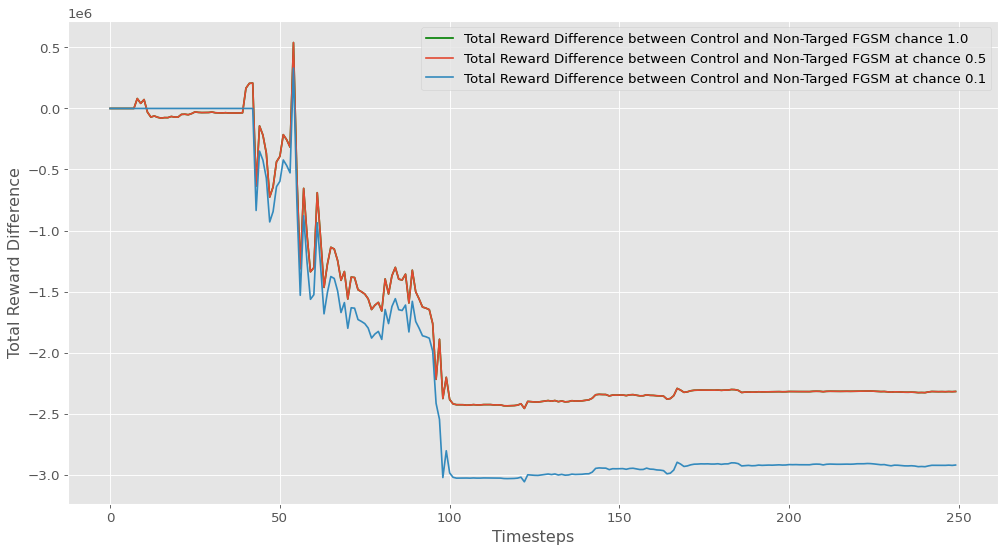

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot(networth0,label="Net-Worth of Control",color='red')
plt.plot( np.array(nontargetfgsm_reward_array) - np.array(control_reward_array),label="Total Reward Difference between Control and Non-Targed FGSM chance 1.0",color='green')
plt.plot( np.array(nontargetfgsm_reward_chance1_array) - np.array(control_reward_array),label="Total Reward Difference between Control and Non-Targed FGSM at chance 0.5")
plt.plot( np.array(nontargetfgsm_reward_chance2_array) - np.array(control_reward_array),label="Total Reward Difference between Control and Non-Targed FGSM at chance 0.1")
plt.ylabel("Total Reward Difference")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_fgsm_nontarget_trd.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


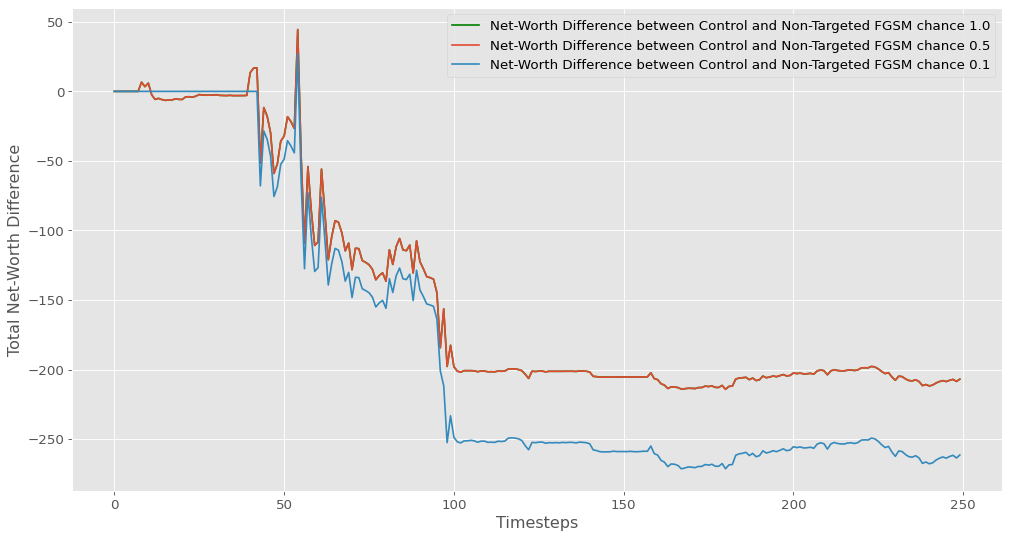

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot(networth0,label="Net-Worth of Control",color='red')
plt.plot( np.array(networth1) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 1.0",color='green')
plt.plot( np.array(networth2) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 0.5")
plt.plot( np.array(networth3) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 0.1")
plt.ylabel("Total Net-Worth Difference")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_fgsm_nontarget_networthdiff.eps")
plt.show()

In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
worst_actions = agent3.get_trajectory(n_steps=250,max=False)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:02<00:00, 95.12it/s]

431881.3502740403


In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
targetfgsm_mean_reward, targetfgsm_reward_array,fgsm_other,networth10 = agent3.target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=1.0,iterations=5,start_eps=0.1,end_eps=3.0,max_actions=true_actions,writeToFile=True,min_actions=worst_actions)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|█████████▉| 249/250 [00:18<00:00, 13.59it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 86944227.88769181
Mean Reward: 347776.91155076725
PertCount: 248
FailCount: 248
Non-Target Count: 146
noChangeNeeded: 1
PartialSuccess: 230
Agent's Net Worth: 88581.04353552239


In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
targetfgsm_mean_reward_chance1, targetfgsm_reward_chance1_array,fgsm_other2,networth11 = agent3.target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=0.5,iterations=5,start_eps=0.1,end_eps=3.0,max_actions=true_actions,writeToFile=False,min_actions=worst_actions)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:09<00:00, 21.63it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 102042457.44604117
Mean Reward: 408169.82978416467
PertCount: 123
FailCount: 123
Non-Target Count: 65
noChangeNeeded: 0
PartialSuccess: 122
Agent's Net Worth: 89915.72416455399


In [ ]:
env3 = copy.deepcopy(env)
agent3 = DQNAgent2(env3)
agent3.restore(current_policy)
targetfgsm_mean_reward_chance2, targetfgsm_reward_chance2_array,fgsm_other3,networth12 = agent3.target_fgsm(n_steps=250,n_episodes=1,render_interval=None,chance=0.1,iterations=5,start_eps=0.1,end_eps=3.0,max_actions=true_actions,writeToFile=False,min_actions=worst_actions)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 99%|█████████▉| 248/250 [00:04<00:00, 63.93it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 107181122.89342757
Mean Reward: 428724.4915737103
PertCount: 28
FailCount: 28
Non-Target Count: 9
noChangeNeeded: 1
PartialSuccess: 27
Agent's Net Worth: 90371.7188426086


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


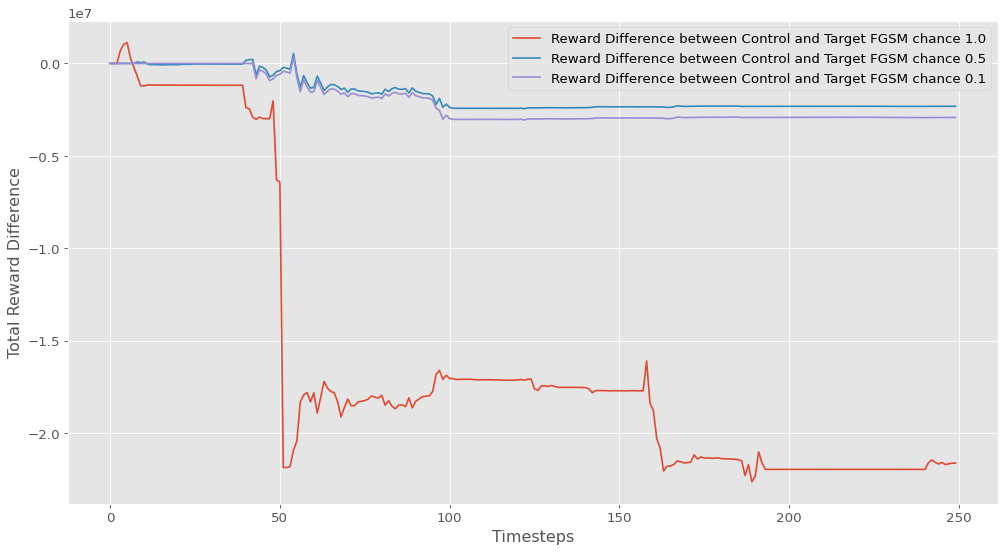

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot( np.array(targetnp.array(control_reward_array),label="Control",color='red')
plt.plot( np.array(targetfgsm_reward_array) - np.array(control_reward_array),label="Reward Difference between Control and Target FGSM chance 1.0")
plt.plot( np.array(nontargetfgsm_reward_chance1_array) - np.array(control_reward_array),label="Reward Difference between Control and Target FGSM chance 0.5")
plt.plot( np.array(nontargetfgsm_reward_chance2_array) - np.array(control_reward_array),label="Reward Difference between Control and Target FGSM chance 0.1")
#plt.plot(delay_reward_chance3_array,label="Non-Target FGSM at chance 0.01",alpha=.5,color='blue')
plt.ylabel("Total Reward Difference")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_rd_targetfgsm.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


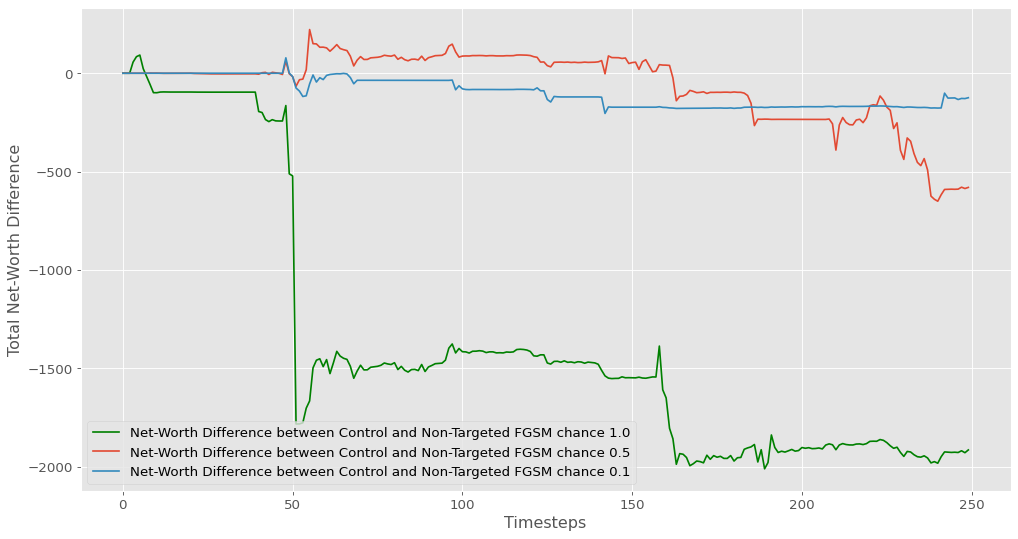

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot(networth0,label="Net-Worth of Control",color='red')
plt.plot( np.array(networth10) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 1.0",color='green')
plt.plot( np.array(networth11) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 0.5")
plt.plot( np.array(networth12) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted FGSM chance 0.1")
plt.ylabel("Total Net-Worth Difference")
plt.xlabel("Timesteps")
plt.legend(loc=3)
plt.savefig("tt_fgsm_target_networthdiff.eps")
plt.show()

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import namedtuple
import tqdm

from tensortrade.agents import Agent, ReplayMemory


DQNTransition = namedtuple('DQNTransition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent4(Agent):

    def __init__(self,
                 env: 'TradingEnv',
                 policy_network: tf.keras.Model = None):
        self.env = env
        self.n_actions = env.action_space.n
        self.observation_shape = env.observation_space.shape

        self.policy_network = policy_network or self._build_policy_network()

        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

        self.env.agent_id = self.id

    def _build_policy_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.observation_shape),
            tf.keras.layers.Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_actions, activation="sigmoid"),
            tf.keras.layers.Dense(self.n_actions, activation="softmax")
        ])

        return network

    def restore(self, path: str, **kwargs):
        self.policy_network = tf.keras.models.load_model(path)
        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

    def save(self, path: str, **kwargs):
        episode: int = kwargs.get('episode', None)

        if episode:
            filename = "policy_network__" + self.id + "__" + str(episode).zfill(3) + ".hdf5"
        else:
            filename = "policy_network__" + self.id + ".hdf5"

        self.policy_network.save(path + filename)

    def get_action(self, state: np.ndarray, **kwargs) -> int:
        threshold: float = kwargs.get('threshold', 0)

        rand = random.random()

        if rand < threshold:
            choice = np.random.choice(self.n_actions)
            return choice
        else:
            choice = np.argmax(self.policy_network(np.expand_dims(state, 0)))
            return choice
    def get_action_greedy(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmax(qvalues)
        return choice

    def train(self,
              n_steps: int = None,
              n_episodes: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        stop_training = False

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        pass

    def record_state_action(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              chance: float = 1.0,
              iterations: int =5,
              cw_lr: float = 0.5,
              c_val: float = 0.1,
              max_actions: bool = False,
              writeToFile: bool = False,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        state_action=[]


        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))


        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                action = self.get_action_greedy(state)

                state_action.append([state,action])
                

                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                steps_done += 1
                total_steps_done +=1

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        return state_action

In [ ]:
env5 = copy.deepcopy(env)
agent5 = DQNAgent4(env3)
agent5.restore(current_policy)
state_action = agent5.record_state_action(n_steps=250,n_episodes=1,render_interval=None,chance=0.1,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=1,cw_lr=0.5)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:02<00:00, 99.85it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

100%|██████████| 250/250 [00:02<00:00, 88.21it/s]


# CW ATTACK 


In [ ]:
def cw_attack(model,x,label,targeted=False,c=0.1,k=0,max_iter=30,lr=0.5):
  w = tf.Variable(tf.zeros_like(x)) #the change-of-variable we'll optimize for instead directly delta
  opt = tf.keras.optimizers.Adam(lr)
  x = tf.Variable(x)
  def obj_f(i):
    # f(x') = max( max(f(x')) - f(x'), k )
    o = model(tf.expand_dims(i,0))
    ohe = tf.one_hot(tf.math.argmax(o),len(o[0]))
    real = tf.math.reduce_sum(ohe*o,1) #tf.reduce_sum((self.tlab)*self.output,1)
    other = tf.math.reduce_max( (1 - ohe)*o,1 )#tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)
    if targeted:
      return tf.math.maximum(k,(other - real))
    else:
      return tf.math.maximum(k,(real - other))

  def loss(true,pred,delta):
    # L2 of |x - x'| + f(1/2*tanh(w)+1)
    cost = tf.losses.mean_squared_error(true,pred)
    cost =  tf.math.reduce_sum(cost)
    cost2 = tf.math.multiply(c,obj_f(delta))
    cost = cost + cost2
    return cost

  prev = 1e10

  for _ in range(max_iter):
    with tf.GradientTape() as tape:
      tape.watch(w)
      adv = (1/2)*(tf.nn.tanh(w) + 1)
      prediction = model(tf.expand_dims(adv,0))
      loss_val = loss(label,prediction,adv)
      gradients = tape.gradient(loss_val, w)
    opt.apply_gradients(zip([gradients], [w]))

        # Early Stop when loss does not converge.
    if _ % max_iter == 0 :
      if loss_val.numpy()[0] > prev :
          return (1/2)*(tf.nn.tanh(w) + 1)
      prev = loss_val.numpy()[0]
  
  return (1/2)*(tf.nn.tanh(w) + 1)

In [ ]:
ind=20

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import namedtuple
import tqdm

from tensortrade.agents import Agent, ReplayMemory


DQNTransition = namedtuple('DQNTransition', ['state', 'action', 'reward', 'next_state', 'done'])


class DQNAgent3(Agent):

    def __init__(self,
                 env: 'TradingEnv',
                 policy_network: tf.keras.Model = None):
        self.env = env
        self.n_actions = env.action_space.n
        self.observation_shape = env.observation_space.shape

        self.policy_network = policy_network or self._build_policy_network()

        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

        self.env.agent_id = self.id

    def _build_policy_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=self.observation_shape),
            tf.keras.layers.Conv1D(filters=64, kernel_size=6, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="tanh"),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_actions, activation="sigmoid"),
            tf.keras.layers.Dense(self.n_actions, activation="softmax")
        ])

        return network

    def restore(self, path: str, **kwargs):
        self.policy_network = tf.keras.models.load_model(path)
        self.target_network = tf.keras.models.clone_model(self.policy_network)
        self.target_network.trainable = False

    def save(self, path: str, **kwargs):
        episode: int = kwargs.get('episode', None)

        if episode:
            filename = "policy_network__" + self.id + "__" + str(episode).zfill(3) + ".hdf5"
        else:
            filename = "policy_network__" + self.id + ".hdf5"

        self.policy_network.save(path + filename)

    def get_action(self, state: np.ndarray, **kwargs) -> int:
        threshold: float = kwargs.get('threshold', 0)

        rand = random.random()

        if rand < threshold:
            choice = np.random.choice(self.n_actions)
            return choice
        else:
            choice = np.argmax(self.policy_network(np.expand_dims(state, 0)))
            return choice
    def get_action_greedy(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmax(qvalues)
        return choice
    def get_worst_action(self, state: np.ndarray):
        qvalues = self.policy_network(np.expand_dims(state, 0))
        choice = np.argmin(qvalues)
        return choice


    def cw_attack(self,model,x,label,targeted=False,c=0.1,k=0,max_iter=30,lr=0.5):
      w = tf.Variable(tf.zeros_like(x)) #the change-of-variable we'll optimize for instead directly delta
      opt = tf.keras.optimizers.Adam(lr)
      x = tf.Variable(x)

      def obj_f(i):
        # f(x') = max( max(f(x')) - f(x'), k )
        o = model(tf.expand_dims(i,0))
        ohe = tf.one_hot(tf.math.argmax(o),len(o[0]))
        real = tf.math.reduce_sum(ohe*o,1) #tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.math.reduce_max( (1 - ohe)*o,1 )#tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)
        if targeted:
          return tf.math.maximum(k,(other - real))
        else:
          return tf.math.maximum(k,(real - other))

      def loss(true,pred,delta):
        # L2 of |x - x'| + f(1/2*tanh(w)+1)
        cost = tf.losses.mean_squared_error(true,pred)
        cost =  tf.math.reduce_sum(cost)
        cost2 = tf.math.multiply(c,obj_f(delta))
        cost = cost + cost2
        return cost

      prev = 1e10

      for _ in range(max_iter):
        #adv = (1/2)*(tf.nn.tanh(w) + 1)
        with tf.GradientTape() as tape:
          tape.watch(w)
          adv = (1/2)*(tf.nn.tanh(w) + 1)
          prediction = model(tf.expand_dims(adv,0))
          loss_val = loss(label,prediction,adv)
          gradients = tape.gradient(loss_val, w)
        opt.apply_gradients(zip([gradients], [w]))

            # Early Stop when loss does not converge.
        if _ % max_iter == 0 :
          if loss_val.numpy()[0] > prev :
              return (1/2)*(tf.nn.tanh(w) + 1)
          prev = loss_val.numpy()[0]
      
      return (1/2)*(tf.nn.tanh(w) + 1)

    def train(self,
              n_steps: int = None,
              n_episodes: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        stop_training = False

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        pass

    def non_target_cw(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              chance: float = 1.0,
              iterations: int =5,
              cw_lr: float = 0.5,
              c_val: float = 0.1,
              max_actions: bool = False,
              writeToFile: bool = False,
              eps: float = 0.5,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        tra = []
        tra2=[]
        failCount=0
        noChangeNeeded=0
        pertCount=0
        networth=[]

        if writeToFile == True:
          writefile = open('nontarget_cw.txt','w+')

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        def actiontype(a):
          if env.action_scheme.actions[a] == None:
            return "None"
          else:
            return env.action_scheme.actions[a][-1][-1]

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                trueWindow = state[-1].copy()
                action = self.get_action_greedy(state)

                label = max_actions[steps_done] ##the true action to take at a timestep t

                if label!= action and  actiontype(label) != actiontype(action):
                  #agent's action is already not the best action and is not the same type of action
                  noChangeNeeded+=1
                elif steps_done!=0 and np.random.random() < chance:
                  pertCount+=1
                  cw_state = self.cw_attack(model=self.policy_network, x=state, label=label,targeted=False,c=c_val,k=0,max_iter=iterations,lr=cw_lr)
                  #state shape is (20,3), fgsm_state is shape (1,20,3)
                  tupleinQ= cw_state[-1].numpy()
                  tupleinQ[0] = tupleinQ[0]*0.01
                  state[-1] =tupleinQ*eps + state[-1]
                  #to make this adversarial attack more constrained, we must abide by the direction of the prices.
                  for i in range(len(trueWindow)):
                      if trueWindow[i] >= 0 and state[-1][i] <= 0:
                        state[-1][i] = -state[-1][i]
                      elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                        state[-1][i] =-state[-1][i]
                  action = self.get_action_greedy(state)

                  if label==action or actiontype(label) == actiontype(action):
                    ##final check for action
                    failCount+=1
                    #reassign the modified state to the original if the attack fails
                    state[-1] =trueWindow
                  else:
                    if writeToFile == True:
                      writefile.write("\n Timestep:"+str(steps_done))
                      writefile.write("\n True OBS:"+str(trueWindow))
                      writefile.write("\n Perturbed OBS:"+str(state[-1]))
                      writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                      writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                prev_state = state.copy()

                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                tra.append(total_reward)
                networth.append(self.env.action_scheme.portfolio.net_worth)
                steps_done += 1
                total_steps_done +=1

                state[:-1] = prev_state[1:]

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        print("Total Reward:",total_reward)
        print("Mean Reward:",mean_reward)
        print("PertCount:",pertCount)
        print("FailCount:", failCount)
        print("noChangeNeeded:",noChangeNeeded)
        print("Agent's Net Worth:",env.action_scheme.portfolio.net_worth)
        others=[]
        others =[
        self.env.action_scheme.portfolio.net_worth,\
        self.env.action_scheme.portfolio.initial_balance,\
        self.env.action_scheme.portfolio.initial_net_worth,\
        self.env.action_scheme.portfolio.balances,\
        self.env.action_scheme.portfolio.ledger.transactions
        ]
        if writeToFile == True:
          writefile.close()
        return mean_reward,tra,others,networth




    def target_cw(self,
              n_steps: int = None,
              save_every: int = None,
              save_path: str = None,
              callback: callable = None,
              n_episodes: int = 1,
              chance: float = 1.0,
              iterations: int =5,
              start_eps: float = 0.001,
              end_eps: float = 0.01,
              max_actions: bool = False,
              min_actions: bool = False,
              writeToFile: bool = False,
              eps: float = 0.5,
              **kwargs) -> float:
        batch_size: int = kwargs.get('batch_size', 128)
        discount_factor: float = kwargs.get('discount_factor', 0.9999)
        learning_rate: float = kwargs.get('learning_rate', 0.0001)
        eps_start: float = kwargs.get('eps_start', 0.9)
        eps_end: float = kwargs.get('eps_end', 0.05)
        eps_decay_steps: int = kwargs.get('eps_decay_steps', 200)
        update_target_every: int = kwargs.get('update_target_every', 1000)
        memory_capacity: int = kwargs.get('memory_capacity', 1000)
        render_interval: int = kwargs.get('render_interval', 50)  # in steps, None for episode end renderers only

        memory = ReplayMemory(memory_capacity, transition_type=DQNTransition)
        episode = 0
        total_steps_done = 0
        total_reward = 0
        pbar = tqdm.tqdm(range(n_steps),leave=True,position=0)
        bar=20
        tra = []
        tra2=[]
        failCount=0
        noChangeNeeded=0
        pertCount=0
        nontargetattack=0
        networth=[]
        partialSuccess=0

        def actiontype(a):
          if env.action_scheme.actions[a] == None:
            return "None"
          else:
            return env.action_scheme.actions[a][-1][-1]

        if writeToFile == True:
          writefile = open('target_cw.txt','w+')

        if n_steps and not n_episodes:
            n_episodes = np.iinfo(np.int32).max

        print('====      AGENT ID: {}      ===='.format(self.id))

        while episode < n_episodes:
            state = self.env.reset()
            done = False
            steps_done = 0

            while not done:
                trueWindow = state[-1].copy()
                action = self.get_action_greedy(state)

                best = max_actions[steps_done] ##the true action to take at a timestep t
                label = min_actions[steps_done] ##the desired action to take at a timestep t

                if label == action:
                  #agent's action is what we want
                  noChangeNeeded+=1
                elif steps_done!=0 and np.random.random() < chance:
                  pertCount+=1
                  state[-1] =trueWindow
                  cw_state = self.cw_attack(self.policy_network, state, label,targeted=True,c=0.1,k=0,max_iter=30,lr=0.5)
                  #state shape is (20,3), fgsm_state is shape (1,20,3)
                  tupleinQ= cw_state[-1].numpy()
                  tupleinQ[0] = tupleinQ[0]*0.01
                  state[-1] =tupleinQ*eps + state[-1]
                  #to make this adversarial attack more constrained, we must abide by the direction of the prices.
                  for i in range(len(trueWindow)):
                      if trueWindow[i] >= 0 and state[-1][i] <= 0:
                        state[-1][i] = -state[-1][i]
                      elif trueWindow[i] <= 0 and state[-1][i] >= 0:
                        state[-1][i] =-state[-1][i]
                  action = self.get_action_greedy(state)

                  if label!=action:
                    failCount+=1
                    ##final check for action
                    if action != best:
                      #is a nontarget attack
                      nontargetattack+=1
                    if actiontype(label)!=actiontype(action):
                      ## we have at least changed the action to the same action type
                      partialSuccess+=1
                      #we will be lenient to perserve partial success attacks
                      if writeToFile == True:
                        writefile.write("\n Partial Success")
                        writefile.write("\n Timestep:"+str(steps_done))
                        writefile.write("\n True OBS:"+str(trueWindow))
                        writefile.write("\n Perturbed OBS:"+str(state[-1]))
                        writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                        writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                    else:
                      #reassign the modified state to the original if the attack completely fails
                      state[-1] =trueWindow
                  else:
                    if writeToFile == True:
                      writefile.write("\n Full Success")
                      writefile.write("\n Timestep:"+str(steps_done))
                      writefile.write("\n True OBS:"+str(trueWindow))
                      writefile.write("\n Perturbed OBS:"+str(state[-1]))
                      writefile.write("\n (true actio index, adversarial action index):"+str(label)+","+str(action))
                      writefile.write("\n (true action, adversarial action):"+str(env.action_scheme.actions[label])+","+str(env.action_scheme.actions[action]))
                prev_state = state.copy()

                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                total_reward += reward
                tra.append(total_reward)
                networth.append(self.env.action_scheme.portfolio.net_worth)
                steps_done += 1
                total_steps_done +=1

                state[:-1] = prev_state[1:]

                pbar.update(1)

                if n_steps and steps_done >= n_steps:
                    done = True

            if not render_interval or steps_done < n_steps:
                self.env.render(
                    episode=episode,
                    max_episodes=n_episodes,
                    max_steps=n_steps
                )  # renderers final state at episode end if not rendered earlier

            self.env.save()

            episode += 1

        mean_reward = total_reward / steps_done
        print("Total Reward:",total_reward)
        print("Mean Reward:",mean_reward)
        print("PertCount:",pertCount)
        print("FailCount:", failCount)
        print("Non-Target Count:",nontargetattack)
        print("noChangeNeeded:",noChangeNeeded)
        print("PartialSuccess:",partialSuccess)
        print("Agent's Net Worth:",self.env.action_scheme.portfolio.net_worth)
        others=[]
        others =[
        self.env.action_scheme.portfolio.net_worth,\
        self.env.action_scheme.portfolio.initial_balance,\
        self.env.action_scheme.portfolio.initial_net_worth,\
        self.env.action_scheme.portfolio.balances,\
        self.env.action_scheme.portfolio.ledger.transactions
        ]
        if writeToFile == True:
          writefile.close()
        return mean_reward,tra,others,networth

In [ ]:
env4 = copy.deepcopy(env)
agent4 = DQNAgent3(env3)
agent4.restore(current_policy)
nontargetcw_mean_reward1, nontargetcw_reward_array1,nontargetcw1_other,networth201 = agent4.non_target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=1,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=0.1,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [05:13<00:00,  1.25s/it]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 109009140.56185156
Mean Reward: 436036.5622474062
PertCount: 246
FailCount: 240
noChangeNeeded: 3
Agent's Net Worth: 90496.2333227268


In [ ]:
env4 = copy.deepcopy(env)
agent4 = DQNAgent3(env3)
agent4.restore(current_policy)
nontargetcw_mean_reward, nontargetcw_reward_array,nontargetcw_other,networth20 = agent4.non_target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=0.1,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=0.1,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|█████████▉| 249/250 [00:24<00:00,  9.56it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 108564998.53357518
Mean Reward: 434259.99413430074
PertCount: 17
FailCount: 17
noChangeNeeded: 0
Agent's Net Worth: 90496.2333227268


In [ ]:
env4 = copy.deepcopy(env)
agent4 = DQNAgent3(env3)
agent4.restore(current_policy)
nontargetcw_mean_reward2, nontargetcw_reward_array2,nontargetcw_other2,networth202 = agent4.non_target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=0.5,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=0.01,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

 99%|█████████▉| 247/250 [02:27<00:02,  1.37it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 109242835.20900427
Mean Reward: 436971.34083601704
PertCount: 114
FailCount: 110
noChangeNeeded: 3
Agent's Net Worth: 90496.2333227268


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


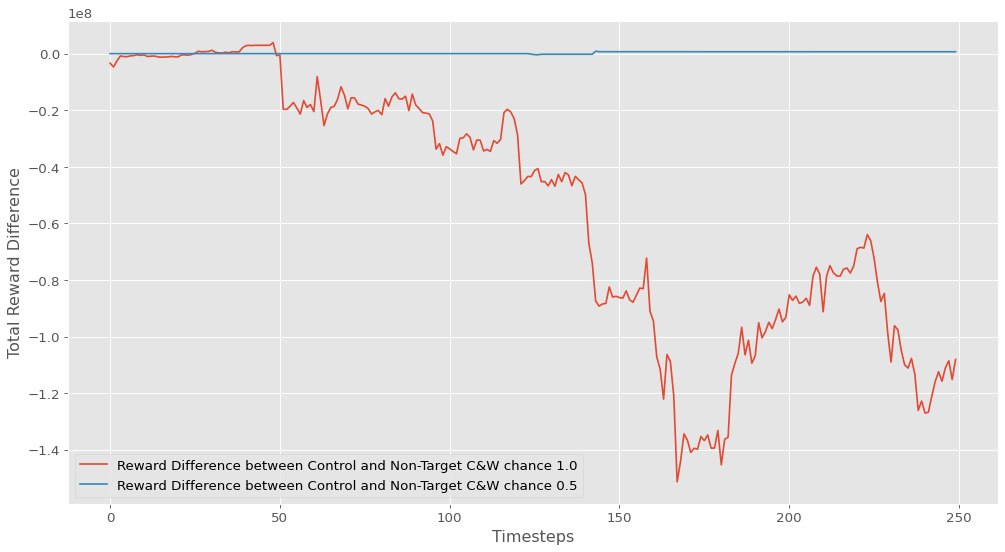

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot( np.array(targetnp.array(control_reward_array),label="Control",color='red')
plt.plot( np.array(nontargetcw_mean_reward1) - np.array(control_reward_array),label="Reward Difference between Control and Non-Target C&W chance 1.0")
plt.plot( np.array(nontargetcw_reward_array2) - np.array(control_reward_array),label="Reward Difference between Control and Non-Target C&W chance 0.5")
#plt.plot( np.array(nontargetcw_reward_array) - np.array(control_reward_array),label="Reward Difference between Control and Non-Target C&W chance 0.1")
#plt.plot(delay_reward_chance3_array,label="Non-Target FGSM at chance 0.01",alpha=.5,color='blue')
plt.ylabel("Total Reward Difference")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_rd_nontargetcw.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


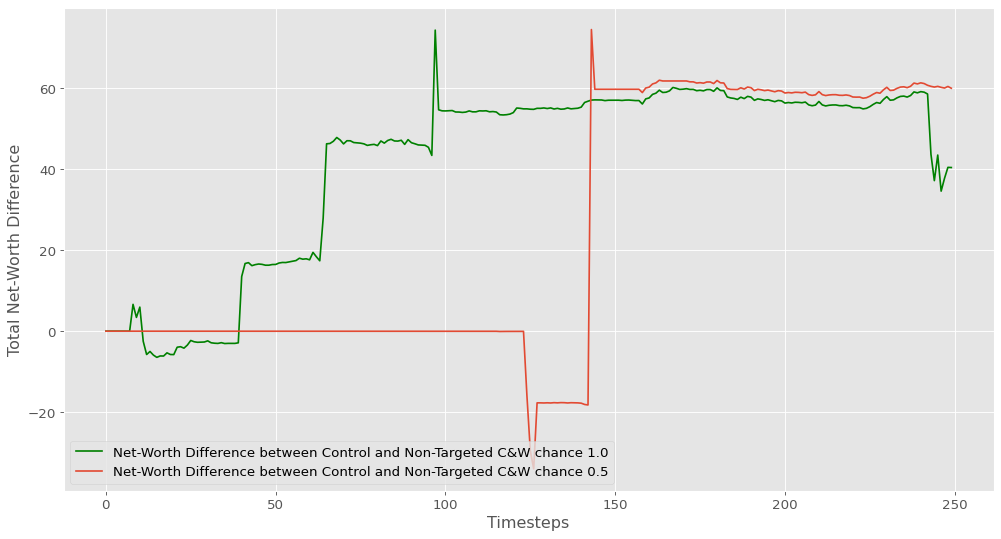

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot(networth0,label="Net-Worth of Control",color='red')
plt.plot( np.array(networth201) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted C&W chance 1.0",color='green')
plt.plot( np.array(networth202) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted C&W chance 0.5")
#plt.plot( np.array(networth20) - np.array(networth0),label="Net-Worth Difference between Control and Non-Targeted C&W chance 0.1")
plt.ylabel("Total Net-Worth Difference")
plt.xlabel("Timesteps")
plt.legend(loc=3)
plt.savefig("tt_cw_nontarget_networthdiff.eps")
plt.show()

In [ ]:
 np.array(networth201) - np.array(networth0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  6.62613018,  3.40030505,
        5.94537439, -2.50215455, -5.76678605, -5.01714871, -5.90967857,
       -6.46750973, -6.12580164, -6.14274101, -5.3573311 , -5.76447858,
       -5.78720093, -3.96338427, -3.83910691, -4.19431758, -3.44123386,
       -2.29862409, -2.61968404, -2.74832169, -2.71695962, -2.67751783,
       -2.39185721, -2.86600918, -2.9768927 , -3.02367002, -2.8442152 ,
       -3.05543693, -3.01395905, -3.02439112, -3.0203852 , -2.8789932 ,
       13.49767874, 16.72196866, 16.9342681 , 16.18703613, 16.441896  ,
       16.59634183, 16.51102158, 16.30166501, 16.30494436, 16.46854336,
       16.48695643, 16.84385717, 16.98005314, 16.96031507, 17.12637191,
       17.27962508, 17.45072105, 18.02687119, 17.79044662, 17.88578442,
       17.63788457, 19.4742656 , 18.38994029, 17.39412311, 27.96633753,
       46.30089796, 46.38405211, 46.92707023, 47.86045751, 47.24

In [ ]:
 np.array(networth202) - np.array(networth0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        4.99279835,  4.71015037,  4.44775725,  5.2661484 ,  5.0573236 ,
        5.18330843,  5.19051166,  5.20818675,  5.24186525,  5.19465012,
        5.19554712,  5.05862436,  5.5121188 ,  5.96056908,  6.46520407,
        3.37515407, -0.1698606 ,  1.43045026,  0.2714611 ,  0.76516882,
       -0.39725513,  3.8883995 ,  0.90095577, -2.31767223,  8.51048167,
       27.21490514, 27.36683874, 28.35900457, 30.06442643, 28.96

In [ ]:
np.array(networth20) - np.array(networth0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
env5 = copy.deepcopy(env)
agent5 = DQNAgent3(env5)
agent5.restore(current_policy)
targetcw_mean_reward2, targetcw_reward_array2,nontargetcw_other2,networth302 = agent5.target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=0.5,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=0.1,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:54<00:00,  3.52it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 98770845.64028059
Mean Reward: 395083.38256112236
PertCount: 131
FailCount: 131
Non-Target Count: 25
noChangeNeeded: 0
PartialSuccess: 127
Agent's Net Worth: 89626.0577658134


In [ ]:
env5 = copy.deepcopy(env)
agent5 = DQNAgent3(env5)
agent5.restore(current_policy)
targetcw_mean_reward1, targetcw_reward_array1,targetcw_other1,networth301 = agent5.target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=1,iterations=100,max_actions=true_actions,writeToFile=True,min_actions=worst_actions,c_val=0.1,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [01:40<00:00,  2.50it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 97643633.05909961
Mean Reward: 390574.53223639843
PertCount: 249
FailCount: 249
Non-Target Count: 70
noChangeNeeded: 0
PartialSuccess: 243
Agent's Net Worth: 89526.1802580086


In [ ]:
env5 = copy.deepcopy(env)
agent5 = DQNAgent3(env5)
agent5.restore(current_policy)
targetcw_mean_reward3, targetcw_reward_array3,targetcw_other3,networth303 = agent5.target_cw(n_steps=250,n_episodes=1,render_interval=None,chance=0.1,iterations=100,max_actions=true_actions,writeToFile=False,min_actions=worst_actions,c_val=0.1,cw_lr=0.5,eps=1)

/content/TensorTrader/tensortrade/feed/core/operators.py:171: RuntimeWarning:

divide by zero encountered in true_divide

100%|██████████| 250/250 [00:12<00:00, 31.58it/s]

FigureWidget({
    'data': [{'close': array([7150.35, 7194.52, 7217.  , ..., 8054.66, 8109.53, 8050.94]),
    …

Total Reward: 103704179.82892719
Mean Reward: 414816.71931570873
PertCount: 26
FailCount: 26
Non-Target Count: 5
noChangeNeeded: 0
PartialSuccess: 26
Agent's Net Worth: 90063.75348101079


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


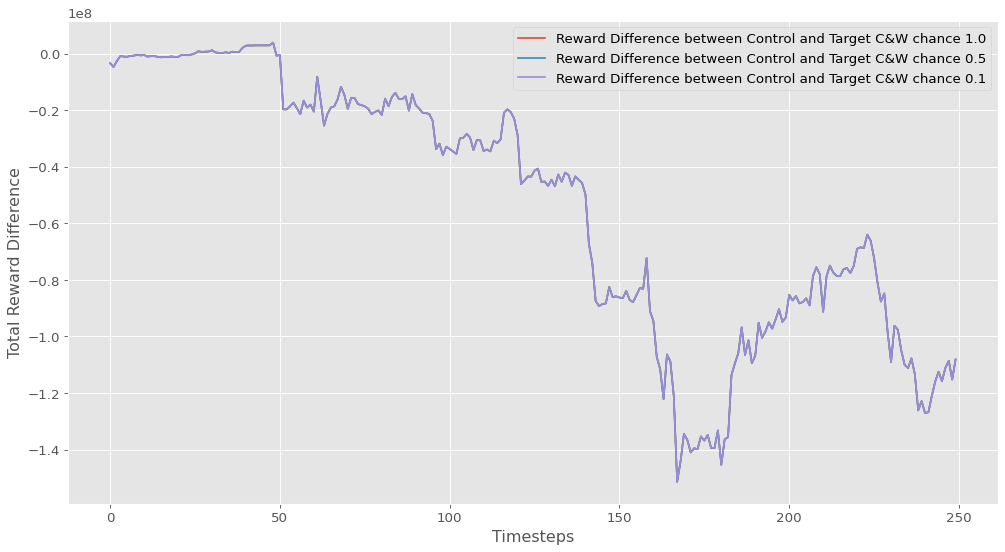

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot( np.array(targetnp.array(control_reward_array),label="Control",color='red')
plt.plot( np.array(targetcw_mean_reward1) - np.array(control_reward_array),label="Reward Difference between Control and Target C&W chance 1.0")
plt.plot( np.array(targetcw_mean_reward2) - np.array(control_reward_array),label="Reward Difference between Control and Target C&W chance 0.5")
plt.plot( np.array(targetcw_mean_reward3) - np.array(control_reward_array),label="Reward Difference between Control and Target C&W chance 0.1")
#plt.plot(delay_reward_chance3_array,label="Non-Target FGSM at chance 0.01",alpha=.5,color='blue')
plt.ylabel("Total Reward Difference")
plt.xlabel("Timesteps")
plt.legend()
plt.savefig("tt_rd_targetcw.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


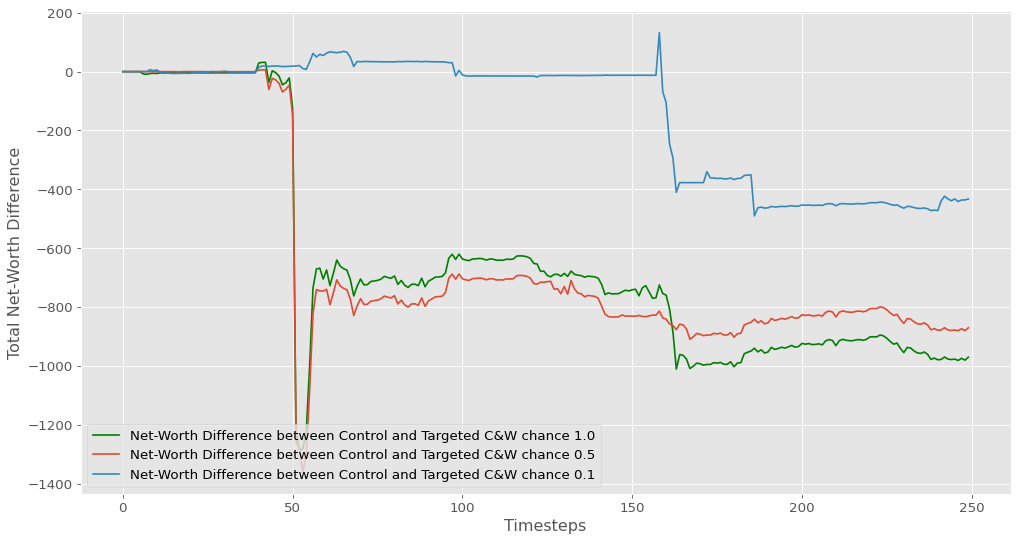

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 12})
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

#plt.plot(networth0,label="Net-Worth of Control",color='red')
plt.plot( np.array(networth301) - np.array(networth0),label="Net-Worth Difference between Control and Targeted C&W chance 1.0",color='green')
plt.plot( np.array(networth302) - np.array(networth0),label="Net-Worth Difference between Control and Targeted C&W chance 0.5")
plt.plot( np.array(networth303) - np.array(networth0),label="Net-Worth Difference between Control and Targeted C&W chance 0.1")
plt.ylabel("Total Net-Worth Difference")
plt.xlabel("Timesteps")
plt.legend(loc=3)
plt.savefig("tt_cw_target_networthdiff.eps")
plt.show()